In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

## Fashion MNIST

In [2]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# load the training and test data
trainset = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='../data', download=True, train=False, transform=transform)

In [3]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)

## Visualizing Dataset

Class name: Ankle boot


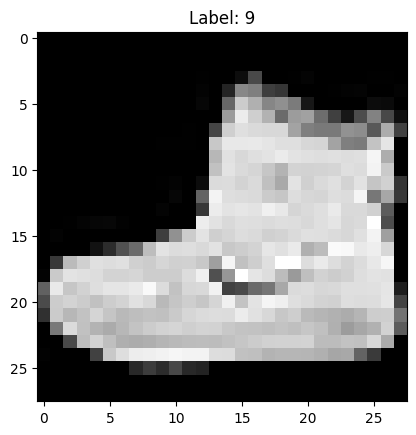

In [5]:
images, labels = next(iter(train_loader))
idx = 0
image = images[idx]
class_name = class_names[labels[idx].item()]
print(f'Class name: {class_name}')
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[idx].item()}')
plt.show()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
	torch.cuda.manual_seed(42)
else:
	torch.manual_seed(42)
    
print(device)

cuda


## Stacked Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 28 * 28)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = self.reshape(x)
        return x

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y = None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model Initialization

In [8]:
stacked_ae = StackedAutoEncoder().to(device=device)
total_params = sum(p.numel() for p in stacked_ae.parameters())
trainable_params = sum(p.numel() for p in stacked_ae.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')
print(f'Non-trainable parameters: {non_trainable_params}')

Total parameters: 163814
Trainable parameters: 163814
Non-trainable parameters: 0


## Model Summary

In [9]:
import torchsummary

In [10]:
torchsummary.summary(stacked_ae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 30]           3,030
           Encoder-3                   [-1, 30]               0
            Linear-4                  [-1, 100]           3,100
            Linear-5                  [-1, 784]          79,184
         Unflatten-6            [-1, 1, 28, 28]               0
           Decoder-7            [-1, 1, 28, 28]               0
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.62
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


In [11]:
for name, param in stacked_ae.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

encoder.fc1.weight: 78400 parameters
encoder.fc1.bias: 100 parameters
encoder.fc2.weight: 3000 parameters
encoder.fc2.bias: 30 parameters
decoder.fc1.weight: 3000 parameters
decoder.fc1.bias: 100 parameters
decoder.fc2.weight: 78400 parameters
decoder.fc2.bias: 784 parameters


## Loss, Optimizer

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr = 0.001)

## Find good initial Learning Rate

### 1. Using lr range

In [13]:
def find_init_lr(model, criterion, optimizer, device, train_loader, num_iterations = 1000):
    
    lre = torch.linspace(-3, 0, num_iterations).to(device) # 10**3 = 0.001, 10**0 = 1
    lrs = 10**lre.cpu()

    plt.plot(lrs, lre.cpu())
    plt.show()
    
    lre_i = [] # lre for i_th iter
    lrs_i = [] # lrs for i_th iter
    
    loss_i = [] # loss for i_th iter
    model.train()
    
    data_iter = iter(train_loader)
    
    print("\nOverfitting on dataset to check training stability and learning rate...")

    for i in range(num_iterations):
        try:
            data,_ = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            data,_ = next(data_iter)
        
        data = data.to(device)
        targets = data.clone().to(device)
        # Zero grad
        optimizer.zero_grad()
        
        # Forward Pass
        y_pred = stacked_ae(data)
        
        # Calculate loss
        loss = criterion(y_pred, targets)
        
        # Optimization
        loss.backward()
        ## Dynamic LR
        lr = lrs[i].item()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad # Update weights
        
        lre_i.append(lre[i].item())  
        lrs_i.append(lrs[i].item())  
        loss_i.append(loss.item())
        if (i + 1) % 100 == 0:
            print(f'Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}')
    return lre_i, lrs_i, loss_i

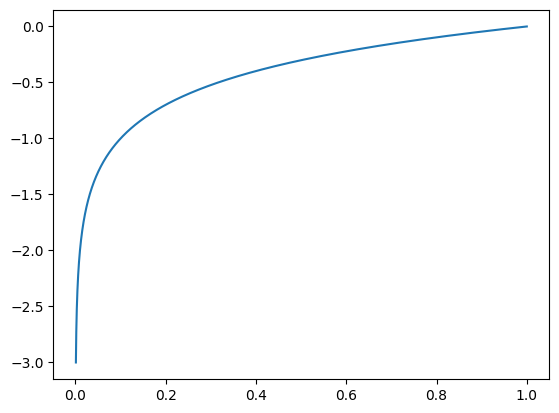


Overfitting on dataset to check training stability and learning rate...
Iteration 100/1000, Loss: 0.681472
Iteration 200/1000, Loss: 0.700884
Iteration 300/1000, Loss: 0.726644
Iteration 400/1000, Loss: 0.684545
Iteration 500/1000, Loss: 0.670039
Iteration 600/1000, Loss: 0.602706
Iteration 700/1000, Loss: 0.370054
Iteration 800/1000, Loss: 0.347545
Iteration 900/1000, Loss: 0.212925
Iteration 1000/1000, Loss: 0.364648


In [14]:
lre_i, lrs_i, loss_i = find_init_lr(stacked_ae, criterion, optimizer, device, train_loader)

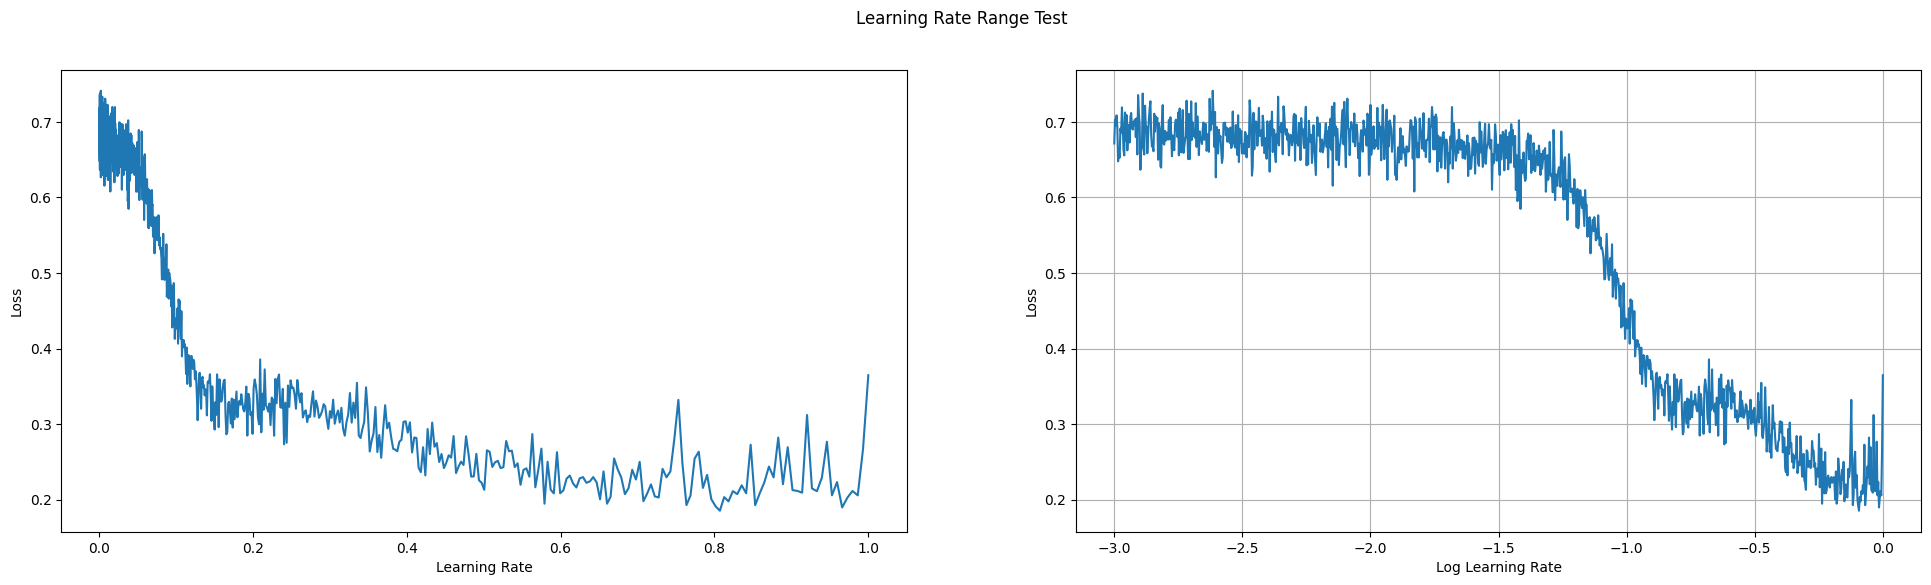

In [15]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(lrs_i, loss_i)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(lre_i, loss_i)
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.suptitle('Learning Rate Range Test')
plt.grid(True)
plt.show()

we can use lr of 0.05 to 0.2 (picked = 0.05)

### 2. Using `torch_lr_finder`  to Find a Good Learning Rate

In [13]:
from torch_lr_finder import LRFinder #!pip install torch-lr-finder

In [14]:
del stacked_ae
stacked_ae = StackedAutoEncoder().to(device=device)

In [15]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    """
    A wrapper that takes a base Dataset returning (x, label)
    and instead returns (x, x) LRFinder that expects (input, target).
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        # in case of autoencoder, target == x, so
        return x, x

train_lrfinder_dataset = AutoencoderDataset(trainset)
train_lrfinder_loader = torch.utils.data.DataLoader(
    train_lrfinder_dataset,
    batch_size = 32,
    shuffle=False
)

In [24]:
lr_finder = LRFinder(stacked_ae, optimizer, criterion, device=device)

In [17]:
lr_finder.range_test(
    train_lrfinder_loader,
    end_lr=1,      
    num_iter=1000,   
    step_mode="exp"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.75E-02


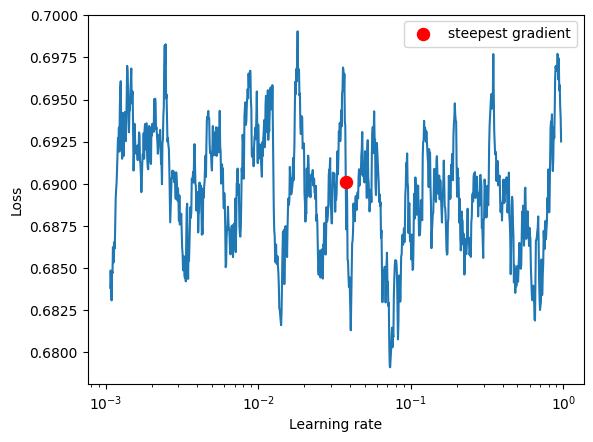

In [20]:
lr_finder.plot()
lr_finder.reset()

In [19]:
3.75E-02

0.0375